# Covariance matrix change-point detection under graph stationarity assumption


## Problem formulation

Let $y = (y_1, \ldots, y_t, \ldots, y_T), y_t \in \mathbb{R}^{N}$ a graph signal lying on the nodes of the graph $G = (V, E, W)$, with $N =|V|$.

We aim at detecting changes of the (spatial) covariance matrix $\Sigma_t$ of the graph signals $y_t$. We assume that there exits an unknown set of change-points $\Tau = (t_1, \ldots, t_K) \subset [1, T]$ with unknown cardinality such that the covariance matrix of the graph signals is constant over any segment $[t_k, t_{k+1}]$. We do the following hypothesis:

1. the signals $y_t$ follow a multivariate Gaussian distribution with fixed covariance matrix over each segment and known mean $\mu$, i.e:
$$\forall k \in [1, K] ~ \forall t \in [t_k, t_{k+1}] \quad y_t \sim \mathcal{N}(\mu, \Sigma_k)$$

2. over each segment, the signals $y_t$ verify the second order wide-sense graph stationarity:
$$\forall k \in [1, K] \quad \Sigma_k = U \text{diag}(\gamma_k)U^T $$

where the matrix $U$ contains the eigenvectors of the graph combinatorial Laplacian matrix $L = D - W$ in its columns. 

The Graph Fourier Transform $\tilde{y}$ of a signal $y$ is defined by $\tilde{y} = U^T y $.


Based on the above assumptions, the cost derived from the maximum log-likelihood over a segment $[a, b-1]$ writes:

\begin{align*}
    c_s(y_{a}, \ldots, y_{b-1}) = ~ & (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + ~ \sum_{t=a}^{b-1} \sum_{n=1}^N \frac{\left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2}{\hat{\gamma}_{a.b}^{(n)}} = ~ (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + N(b-a)
\end{align*}

where:

- $\hat{\mu}_{T}$ is the empirical mean of the process over $[0, T]$
- $\hat{\gamma}^{(n)}_{a..b}$ is the (empirical) biased correlogram/periodogram of the process over $[a, b-1]$: $\hat{\gamma}_{a..b} = \frac{1}{(b-a)} \sum_{t=a}^{b-1} \left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2$

### Observation on the minimum distance between consecutive change points (minimum segment length)

We require that the different change points $(t_1, \ldots, t_K)$ verify:

$$|t_{k+1} - t_k| >= l ~ \forall k \in [1, K-1] $$

where $l$ can be seen as the minimum admissible segment length. In this paragraph we give a meaningful lower bound of this parameter. Such lower bound is related to the computation of the cost functions over the segments $[a, b] \subset [0, T]$, namely the graph stationary normal cost function $c_s$ described above and the standard normal cost function $c_n$:

- $ c_n(y_{a}, \ldots, y_{b-1}) = (b - a) \log  \left[ \det \left( \hat \Sigma_{a..b} \right) \right]$
- $ c_s(y_{a}, \ldots, y_{b-1}) = (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} $

Based on the formula of the spectrogram $\hat{\gamma}_{a.b}$ given in the introduction, there is no numerical constraints for the feasibility of the computation. However, the $\log [ \det ( \cdot ) ]$ function used in the formula for $c_n$ should be applied to invertible matrices $\Sigma_{a..b}$ only. Therefore, we should focus on the conditions under which the matrix:

$$ \hat \Sigma_{a..b} = \frac{1}{b-a} \sum_{t=a}^{b-1} (y_t - \mu_T) (y_t - \mu_T)^T \quad \text{ with } y_t \sim \mathcal{N}(\mu, \Sigma)  $$

is invertible. Actually, such conditions have already been clearly stated in different works from Random Matrix Theory (RMT). For instance, it is shown in [[Izenman2008](#Izenman2008)] that $n \hat \Sigma_{a..b} \sim \mathcal{W}(b-a, \Sigma)$ follows the Wishart distribution. In this framework, it is possible to study the distribution of the eigenvalues of $\hat \Sigma_{a..b}$ and to deduce that: 

$$ \text{If } b-a > N \text{ with } N  \text{ the dimension of } y_t, \text{ then } \hat \Sigma_{a..b} \text{ is almost surely invertible }   $$

Conversely, it is possible to show that if $ b-a < N $ (the number of observations is lower then the number of variables), the matrix $\hat \Sigma_{a..b}$ is nalmost surely not invertible. This can be done by considering the family the first $(N+1)$ columns of $\hat \Sigma_{a..b}$.

Thus, the right lower-bound $l$ should be $\boxed{l = N}$, which is consistent with statement from [[Ryan2023](#Ryan2023)].

Note: with segments of length $l$, one is not guaranteed to compute good estimates of the covariance matrix, but at least such computations is almost surely admissible.

### Synthetic data generation

We design two graph generation scenarios.

1. Erdős–Rényi (ER) graphs with random parameters

In this scenario, we pick random number of nodes $N$ uniformly drawn in $[N_{\min}, N_{\max}]$, that may vary according to the experiment, and a random edge probability $p$ uniformly drawn in $[0.15, 0.5]$. The latter was chosen so that the generated graphs empirically have a realistic connectivity.

2. Geographic-like graphs 

We pick a random number $N$ of nodes uniformly drawn in $[N_{\min}, N_{\max}]$. The nodes are randomly located in $[0, 1]^2$ using the uniform law $\mathcal{U}([0, 1]^2)$. Eventually, we build the adjacency matrix of the graph by applying a threshold $\rho$ to the distance separating the nodes. More formally, if we denote $(W_{ij})_{1 \leq i, j \leq N}$ the coefficients of the adjacency matrix, we explore the following two formulas:

\begin{equation}
    W_{ij} = \mathbb{I} \left( \|p_i - p_j \|_2 \leq \rho \right)
\end{equation}

\begin{equation}
    W_{ij} = \frac{\rho}{\|p_i - p_j \|_2}  \mathbb{I} \left( \|p_i - p_j \|_2 \leq \rho \right)
\end{equation}

where $p_i$ denotes the 2D coordinates of node $i$. In the above formulas, the value of $\rho$ is chosen empirically so that the resulting graphs visually exhibit connectivity patterns that are consistent to what one may expect when using a graph structure for signal analysis. More precisely, we use the following values:

- for $N$ drawn in $[10, 50]$: $~$ $\rho = 0.3$
- for $N$ drawn in $[80, 110]$: $\rho = 0.2$

This scenario simulates 2D geographic graphs and is more likely to match realistic use-cases.


### Signal generation

Let $G$ be a graph randomly generated using one of the above scenarios. We recall that the laplacian matrix $L$ of the graph verifies $L = U \Lambda U^T$, where the columns of $U$ are the eigenvectors of $L$. We now describe how to generate a signal $(y_t)_{1 \leq t \leq T}$ that verifies the hypothesis presented in the [problem formulation](#problem-formulation).

We first pick an admissible number of change points $K$ depending on the signal length $T=1000$ and the minimum segment length $l = N$ by sampling $~  \mathcal{U}([1, \min(\frac{T}{10}, \frac{T}{l})])$. The change points $(t_k)_{1 \leq k \leq K}$ are uniformly drawn in $[l, T-l]$, by checking that a newly selected change point does not break the minimum segment length criteria. Therefore, it may happen that after a limit number of iterations, not $K$ change points were drawn, but we still use the same notations (SHOULD BE CHANGED).

Finally, we apply the following formula to generate the signal $(y_t)_{1 \leq t \leq T}$:



$$ \forall ~ k \in [1, K-1] ~ \forall  t \in [t_k, t_{k+1}] \quad  y_t \sim \mathcal{N}_N(0, \Sigma_k) \quad \text{ with } \quad \Sigma_k = U \text{diag}(\gamma_k) U^T ~  \text{ and } ~ \gamma_k \sim \mathcal{U}niform_N([0, 1]) $$

## Experimental setting v.1

In [ ]:
import os
import warnings
import time
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from numba import njit
from math import floor
from scipy.linalg import eigh
from typing import List
from ruptures.base import BaseCost
from matplotlib.lines import Line2D

import utils as my_ut
import graph_related as my_gr
import signal_related as my_sgn
import result_related as my_res

### Experiments description and visualization

##### A. Data verifying the hypothesis of the model

In this experiment, we generate data according to the hypothesis presented in the [problem formulation](#problem-formulation) and we compare our method to the cost function for standard covariance change detection in Gaussian models (that is supposed to cover our hypothesis). More precisely, we randomly generate a graph and a corresponding multivariate Gaussian signal, undergoing a (known) random number of covariance change points. The comparison between the two methods relies on the precision / recall and Hausdorff metrics.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 3

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G, _ = my_gr.generate_random_geographic_graph_with_gauss_kernel(graph_rng, n_nodes=20, target_degree=10)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G, signal_rng, n_samples=1000, diag_cov_max=10, hyp='min', n_bkps_max=10)

fig, axes = plt.subplot_mosaic(mosaic='ABB', figsize=(14, 3))
nx.draw_networkx(G, ax=axes['A'])
for i in range(6):
    axes['B'].plot(10*i+s[:, i])
axes['B'].set_yticks([])
for bkp in bkps[:-1]:
    axes['B'].axvline(x=bkp, c='k')

##### C. Data verifying the hypothesis of the models, with node dropping to simulate breakdowns

In what follows, we work with signals verifying the two hypothesis from the [the problem formulation](#problem-formulation). Additionally, we will randomly select a (very) small number of nodes and simulate the breakdown of the corresponding sensors by setting the value of the signal lying on this node to 0 for a random time length. 

More formally, let denote $\eta_{max}$ the hyper-parameter corresponding to the maximal proportion of nodes that undergo a breakdown. We denote $N^{max}_{broken} = \lfloor \eta_{max} * N \rfloor$. For each signal $(y_t)_{1 \leq t \leq T} \in \mathbb{R}^{T \times N}$ , we draw $N_{broken}$ number of nodes undergoing a breakdown in $ ~  \mathcal{U}niform([0, N^{max}_{broken}])$. Then, for a node $i$ undergoing a breakdown we apply:

\begin{equation}
    t_{start} ~ \sim ~ \mathcal{U}niform([0, T-1]), ~ t_{end} ~ \sim ~ \mathcal{U}niform([t_{start}, T]) \qquad \forall ~  t \in [t_{start}, t_{end}] ~ y_t^i = 0
\end{equation}

Therefore, by increasing the value of $\eta_{max}$ we evaluate the robustness of our cost function with respect to brutal, isolated and uncorrelated mean changes.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G, _ = my_gr.generate_random_er_graphs_fixed_nodes_nb(graph_rng, nx_graph_seed, n_nodes=30, target_deg=10, bandwidth_coef=0.4)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)
s, breakdowns = my_sgn.modify_signal_to_simulate_breakdown(s, signal_rng, n_breakdown=6, breakdown_length=300)

print("The generated breakdowns are:", breakdowns)

fig, ax = plt.subplots(1, 1, figsize=(12,3))
for i in range(5):
    ax.plot(10*i+s[:, i])
for i, node_id in enumerate(breakdowns.keys()):
    ax.plot(10*(i+5)+s[:, node_id])

##### D. Robustness with respect to (spatially and temporaly) independent additive white noise

In this experiment, we keep using signals that verify our two hypothesis. Though we add a temporally independent white noise with scalar covariance matrix to such signal. More formally, we apply the change point detection algorithm to the signal $(y'_t)_{1 \leq t \leq T}$ defined by

\begin{equation}
    \forall ~  t \in [0, T] \quad y'_t = y_t + e_t \quad \text{ with } \quad e_t \sim \mathcal{N}_N(0, \sigma)
\end{equation}

We evaluate the performance of our cost function against increasing value of $\sigma$.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

# generating noisy signal
G, _ = my_gr.generate_random_geographic_graph_with_gauss_kernel(graph_rng, n_nodes=20, target_degree=10)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)
s_noise = my_sgn.add_diagonal_white_noise(signal_rng, s, sigma=3)

# loading noisy signal
signal_path_no_noise = 'data_1/signal/within_hyp/segment_length_minimal/ER_20_nodes_deg_10_bandwidth_0.4'
signal_no_noise = np.load(f"{signal_path_no_noise}/{0}_signal.npy", allow_pickle=False)
signal_path_noise = 'data_1/signal/diago_noisy_within_hyp/large_x0.4_SNR_0_ER_20_nodes_deg_10_bandwidth_0.4'
signal_noise = np.load(f"{signal_path_noise}/{0}_signal.npy", allow_pickle=False)


fig, axes = plt.subplots(2, 2, figsize=(12,4))
for i in range(5):
    axes[0, 0].plot(10*i+s[:, i])
for i in range(5):
    axes[0, 1].plot(10*i+s_noise[:, i])
for i in range(5):
    axes[1, 0].plot(10*i+signal_no_noise[:400, i])
for i in range(5):
    axes[1, 1].plot(10*i+signal_noise[:400, i])

##### F. Robustness with respect to the graph structure: modification of the connectivity

In this experiment, we do not generate the signal $(y_t)_{1 \leq t \leq T}$ with the graph $G$ that is used to compute the cost function. Instead, we rather utilize the laplacian matrix $L_{noisy}$ of a noisy version $G_{noisy}$ of the original graph $G$.

Let denote $M = |E|$ the number of edges in $G$ and $\eta_{edge}$ the proportion of edges that we modify. We randomly remove $M_{remove} = \lfloor M * \eta_{edge} / 2 \rfloor$ from the set E and we randomly add $M_{add} = \lfloor M * \eta_{edge} / 2 \rfloor$ to $E$. In both cases, we select the edges randomly, but we always check that the resulting noisy graph $G_{noisy}$ still has the same number of nodes as $G$.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed+3)

G, coord = my_gr.generate_random_geographic_graph_with_gauss_kernel(graph_rng, n_nodes=20, target_degree=10)
G_modif = my_gr.modify_graph_connectivity_from_binary_adj_mat_2(G, 0.2, graph_rng)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G_modif, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)

original_edges = set([(min(e), max(e)) for e in G.edges()])
new_edges = set([(min(e), max(e)) for e in G_modif.edges()])


added = new_edges.difference(original_edges)
withdrawn  = original_edges.difference(new_edges)
same = new_edges.intersection(original_edges)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# original graph
nx.draw_networkx_edges(G, pos=coord, edgelist=same, edge_color='k', ax=axes[0])
nx.draw_networkx_edges(G, pos=coord, edgelist=withdrawn, edge_color='r', width=3, ax=axes[0])
nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[0], edgelist = [])
# modified graph
nx.draw_networkx_edges(G_modif, pos=coord, edgelist=same, edge_color='k', ax=axes[1])
nx.draw_networkx_edges(G_modif, pos=coord, edgelist=added, width=3, edge_color='g', ax=axes[1])
nx.draw_networkx(G_modif, with_labels=False, pos=coord, node_size=50, ax=axes[1], edgelist = [])

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed+3)

# G, coord = generate_random_weighted_geographic_graph(graph_rng, min_n_nodes=19, max_n_nodes=20, dist_threshold=0.5)
# # G_modif = modify_graph_connectivity(G, 0.05, graph_rng)
# G_modif = modify_graph_connectivity_from_binary_adj_mat_2(G, 1, graph_rng)
# bkps, s = generate_rd_signal_in_hyp_with_max_tries(G_modif, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)

exp_id = 1

ori_path = "data_1/graphs/clean_ER_with_bandwidth/ER_20_nodes_deg_10_bandwidth_0.4"
adj_mat = np.load(f"{ori_path}/{exp_id}_mat_adj.npy", allow_pickle=False)
G = nx.from_numpy_array(adj_mat)
coord = nx.spring_layout(G, seed=0)
modif_path = "data_1/graphs/ER_with_bd_edge_changed/ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2"
modif_adj_mat = np.load(f"{modif_path}/{exp_id}_mat_adj.npy", allow_pickle=False)
modif_G = nx.from_numpy_array(modif_adj_mat)


original_edges = set([(min(e), max(e)) for e in G.edges()])
new_edges = set([(min(e), max(e)) for e in modif_G.edges()])


added = new_edges.difference(original_edges)
withdrawn  = original_edges.difference(new_edges)
same = new_edges.intersection(original_edges)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# original graph
nx.draw_networkx_edges(G, pos=coord, edgelist=same, edge_color='k', ax=axes[0])
nx.draw_networkx_edges(G, pos=coord, edgelist=withdrawn, edge_color='r', width=3, ax=axes[0])
nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[0], edgelist = [])
# modified graph
nx.draw_networkx_edges(modif_G, pos=coord, edgelist=same, edge_color='k', ax=axes[1])
nx.draw_networkx_edges(modif_G, pos=coord, edgelist=added, width=3, edge_color='g', ax=axes[1])
nx.draw_networkx(modif_G, with_labels=False, pos=coord, node_size=50, ax=axes[1], edgelist = [])

### Plotting utils

In [ ]:
COST_FUNC_NAME_TO_PLOT_LABEL = {
    "statio normal cost": "GSN cost",
    "normal cost": "MLE cost"
}

In [ ]:
def get_metadata_for_plot(res_path_list):
    metadata = {}
    for serie_id, file_path in enumerate(res_path_list):
        file_information = {}
        exp_metadata = my_ut.open_json(file_path + '/experiment_metadata.json')
        file_information["result folder"] = file_path
        file_information["graph folder"] = exp_metadata["graph folder"]
        file_information["signal folder"] = exp_metadata["signal folder"]
        # graph information
        file_information["graph_type"] = exp_metadata["graph folder"].split('/')[-1].split('_')[0]
        file_information["N=nb_nodes"] = exp_metadata["graph metadata"]["n_nodes"]
        # signal information
        file_information["SNR"] = exp_metadata["signal metadata"]["SNR"]
        if exp_metadata["signal metadata"]["bkps_gap_hyp"] == "large":
            file_information["min segment length"] = f'{exp_metadata["signal metadata"]["min_size_coef"]}xN(N-1)/2'
        else:
            file_information["min_segment_length"] = f'{exp_metadata["signal metadata"]["min_size_coef"]} N'
        # experiment information
        file_information["N_exp"] = exp_metadata["max id experiment subset"]
        metadata[serie_id] = file_information
    return metadata

In [ ]:
def define_subtitle_based_on_exp_metadata(exp_metadata):
    subtitle = ''
    for data_key in exp_metadata[0].keys():
        if 'folder' not in data_key:
            all_values = []
            for serie_id in exp_metadata.keys():
                all_values.append(exp_metadata[serie_id][data_key])
            if len(set(all_values)) == 1:
                subtitle = subtitle + data_key + '=' + str(all_values[0]) + ' ~ '
    return subtitle[:-2]

In [ ]:
def get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, preci_margin):
    # initialization
    stat_per_metric_per_cost_func = {}
    for cost_func in cost_func_keys:
        stat_per_metric_per_cost_func[cost_func] = {}
        for metric in metrics_keys:
            stat_per_metric_per_cost_func[cost_func][metric] = {"mean": [], "std": [], "raw": []}
    # parsing metrics file to store results adequately
    for folder_name in res_folder_list:
        file_metric = my_ut.open_json(os.path.join(folder_name, f"metrics_{preci_margin}.json"))
        for cost_func in cost_func_keys:
            for metric in metrics_keys:
                mean = file_metric[cost_func][metric]["mean"]
                stat_per_metric_per_cost_func[cost_func][metric]["mean"].append(mean)
                std = file_metric[cost_func][metric]["std"]
                stat_per_metric_per_cost_func[cost_func][metric]["std"].append(std)
                raw_str = file_metric[cost_func][metric]["raw"]
                raw = my_ut.turn_str_of_list_into_list_of_float(raw_str)
                stat_per_metric_per_cost_func[cost_func][metric]["raw"].append(raw)
    return stat_per_metric_per_cost_func

In [ ]:
def add_raw_scatter_to_plot(x, res_dic, met_name, cost_func, ax):
    # scatter plot based on the raw values
    raw = np.array(res_dic[cost_func][met_name]["raw"])
    raw.flatten()
    x_scat_val = []
    for x_id in range(len(x)):
        x_scat_val = x_scat_val + [x[x_id]] * len(raw[x_id])
    ax.scatter(x=x_scat_val, y=raw, alpha=0.3, c='k', s=10)
    return ax

In [ ]:
bar_width = 0.21
error_kw = {"capsize": 5, "elinewidth": 0.8, "capthick": 2}

def plot_bar_and_scatter(cost_func_keys, res_dic, abscissa, colors_per_cost_func, met_name, ax, shift= 0.1, to_label=False):
    # plot_x_coord = np.linspace(0, 1, num=(len(abscissa)+1))[:-1]
    for i, cost_func in enumerate(cost_func_keys):
        label = None
        if to_label:
            label = cost_func
        color = colors_per_cost_func[cost_func]
        # bar plot based on the statistics
        x = np.asarray(abscissa) + shift*i
        y = res_dic[cost_func][met_name]["mean"]
        y_err = res_dic[cost_func][met_name]["std"]
        ax.bar(x = x, height=y, yerr=y_err, label=label, width=bar_width, error_kw=error_kw, color=color)
        # scatter plot based on the raw values
        add_raw_scatter_to_plot(x, res_dic, met_name, cost_func, ax)
    return ax

In [ ]:
def standard_plot_plus_fill_between(cost_func_keys, res_dic, abscissa, colors_per_cost_func, met_name, ax, to_label=False):
    for i, cost_func in enumerate(cost_func_keys):
        label_mean = None
        label_std = None
        if to_label:
            label_mean = 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[cost_func] 
            label_std = 'std ' + COST_FUNC_NAME_TO_PLOT_LABEL[cost_func]
        color = colors_per_cost_func[cost_func]
        x = np.asarray(abscissa)
        y = np.asarray(res_dic[cost_func][met_name]["mean"])
        y_err = np.asarray(res_dic[cost_func][met_name]["std"])
        ax.plot(x, y, c=color, label=label_mean, marker='x')
        ax.fill_between(x, y1=y-y_err, y2=y+y_err, color=color, alpha=0.4, label=label_std)
    return ax

In [ ]:
def standard_plot_plus_fill_between_wrt_margin(cost_func_keys, per_margin_res_dic, abscissa, colors_per_cost_func, met_name, preci_margin_list, ax, to_label=False, alpha=0.4):
    for i, cost_func in enumerate(cost_func_keys):
        label_mean = None
        label_std = None
        if to_label:
            label_mean = 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[cost_func] 
            label_std = 'std ' + COST_FUNC_NAME_TO_PLOT_LABEL[cost_func]
        x = np.asarray(abscissa)
        color = colors_per_cost_func[cost_func]
        y_arr = np.empty( (len(per_margin_res_dic[preci_margin_list[0]][cost_func][met_name]["mean"]), len(preci_margin_list)) )
        y_err_arr = np.empty( (len(per_margin_res_dic[preci_margin_list[0]][cost_func][met_name]["mean"]), len(preci_margin_list)) )
        for i, preci_margin in enumerate(preci_margin_list):
            y_arr[:, i] = np.asarray(per_margin_res_dic[preci_margin][cost_func][met_name]["mean"])
            y_err_arr[:, i] = np.asarray(per_margin_res_dic[preci_margin][cost_func][met_name]["std"])
        y = np.mean(y_arr, axis=0)
        y_err = np.mean(y_err_arr, axis=0)
        ax.plot(x, y, c=color, label=label_mean, marker='x')
        ax.fill_between(x, y1=y-y_err, y2=y+y_err, color=color, alpha=alpha, label=label_std, linewidth=0)
    return ax

In [10]:
bar_width = 0.02
error_kw = {"capsize": 5, "elinewidth": 0.8, "capthick": 2}

def plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, abscissa, plot_x_coord, colors_per_cost_func, met_name, ax, shift= 0.1, to_label=False):
    for i, cost_func in enumerate(cost_func_keys):
        label = None
        if to_label:
            label = cost_func
        color = colors_per_cost_func[cost_func]
        # bar plot based on the statistics
        x = [plot_x_coord + shift*i]
        y = res_dic[cost_func][met_name]["mean"]
        y_err = res_dic[cost_func][met_name]["std"]
        ax.bar(x = x, height=y, yerr=y_err, label=label, width=bar_width, error_kw=error_kw, color=color)
        # scatter plot based on the raw values
        add_raw_scatter_to_plot(x, res_dic, met_name, cost_func, ax)
    return ax

In [10]:
def add_errorbar_manually(abscissa, y, yerr, marker, linestyle, linewidth, markersize, color, ax):
    # create top and bottom lim
    y_err_top = [y_pos + yerr_val for y_pos, yerr_val in zip(y, yerr)]
    y_err_bottom = [y_pos - yerr_val for y_pos, yerr_val in zip(y, yerr)]
    # add the top and bottom markers
    ax.scatter(abscissa, y_err_top, s=markersize, c=color, marker=marker)
    ax.scatter(abscissa, y_err_bottom, s=markersize, c=color, marker=marker)
    # add the vertical lines
    ax.vlines(x=abscissa, ymin=y_err_bottom, ymax=y_err_top, color=color, linewidth=linewidth, linestyle=linestyle)
    return ax

In [12]:
def plot_scatter_errorbar(abscissa_pos, cost_func_keys, color, markers, linestyles, met_name, res_dic, ax):
    for i, cost_func in enumerate(cost_func_keys):
        y = res_dic[cost_func][met_name]["mean"]
        y_err = res_dic[cost_func][met_name]["std"]
        ax.plot(abscissa_pos, y, c=color, marker=markers[i], markersize=7, linewidth=2, linestyle=linestyles[i])
        add_errorbar_manually(abscissa_pos, y, y_err, marker=markers[i], linestyle=linestyles[i], linewidth=1, markersize=20, color=color, ax=ax)
    return ax

### Additional cost functions

In [13]:
class CostGraphStatioNormal(BaseCost):

    """
    DISCLAIMER: in the current model, the mean in supposed to be known and constant over different segments,
    so we compute its estimate over the whole available samples.
    """

    model = "graph_sationary_normal_cost"

    def __init__(self, laplacian_mat) -> None:
        """
        Args:
            laplacian_mat (array): the discrete Laplacian matrix of the graph: D - W
            where D is the diagonal matrix diag(d_i) of the node degrees and W the adjacency matrix
        """
        self.graph_laplacian_mat = laplacian_mat
        self.signal = None
        self.gft_square_cumsum = None
        self.gft_mean = None
        self.min_size = laplacian_mat.shape[0]
        super().__init__()
    
    def fit(self, signal):
        """Performs pre-computations for per-segment approximation cost.

        NOTE: the number of dimensions of the signal and their ordering
        must match those of the nodes of the graph.
        The function eigh used below returns the eigenvector corresponding to 
        the ith eigenvalue in the ith column eigvect[:, i]

        Args:
            signal (array): of shape [n_samples, n_dim].
        """
        self.signal = signal
        # computation of the GFSS
        _, eigvects = eigh(self.graph_laplacian_mat)
        gft =  signal @ eigvects # equals signal.dot(eigvects) = eigvects.T.dot(signal.T).T
        self.gft_mean = np.mean(gft, axis=0)
        # computation of the per-segment cost utils
        self.gft_square_cumsum = np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum((gft - self.gft_mean[None, :])**2, axis=0)], axis=0)
        return self

    def error(self, start, end):
        """

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if end - start < self.min_size:
            raise ValueError(f'end - start shoud be higher than {self.min_size}')
        sub_square_sum = self.gft_square_cumsum[end] - self.gft_square_cumsum[start]
        return (end  - start) * np.sum(np.log(sub_square_sum / (end - start)))


In [14]:
from sklearn.covariance import GraphicalLasso, log_likelihood

class CostGraphLasso(BaseCost):

    """
    """

    model = "graph_lasso_mle_cost"

    def __init__(self, pen_mult_coef, add_small_diag=True):
        """Initialize the object.

        Args:
            add_small_diag (bool, optional): For signals with truly constant
                segments, the covariance matrix is badly conditioned, so we add
                a small diagonal matrix. Defaults to True.
        """
        self.signal = None
        self.min_size = 2
        self.n_samples = None
        self.alpha_mult_coef = pen_mult_coef
        # self.pen_coef = pen_coef
        self.add_small_diag = add_small_diag
        super().__init__()
    
    def fit(self, signal) :
        """Set parameters of the instance.
        Args:
            signal (array): signal of shape (n_samples, n_features)
        Returns:
            self
        """
        if signal.ndim == 1:
            self.signal = signal.reshape(-1, 1)
        else:
            self.signal = signal
        self.n_samples, self.n_dims = self.signal.shape
        return self

    def error(self, start, end):
        """

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub_signal = self.signal[start:end, :]
        emp_cov_mat= np.cov(sub_signal.T)
        alpha = self.alpha_mult_coef * np.sqrt(np.log(sub_signal.shape[1]) / sub_signal.shape[0])
        gl_estimator = GraphicalLasso(alpha=alpha, assume_centered=True, covariance='precomputed').fit(emp_cov_mat)
        return - log_likelihood(emp_cov_mat, gl_estimator.get_precision())


### Numba cost functions

In [15]:
def init_station_normal_cost(signal, graph_laplacian_mat):
    '''signal (array): of shape [n_samples, n_dim]'''
    # computation of the graph fourier transform
    _, eigvects = eigh(graph_laplacian_mat)
    gft =  signal @ eigvects # equals signal.dot(eigvects) = eigvects.T.dot(signal.T).T
    gft_mean = np.mean(gft, axis=0)
    # computation of the per-segment cost utils
    gft_square_cumsum = np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum((gft - gft_mean[None, :])**2, axis=0)], axis=0)
    return gft_square_cumsum.astype(np.float64)

@njit
def numba_statio_cost_func(start, end, gft_square_cumsum):
    '''
    Computes the cost over signal[start:end, :] where end is excluded

    gft_square_cumsum (array): of shape [n_samples + 1, n_dim] 
    '''
    sub_square_sum = gft_square_cumsum[end, :] - gft_square_cumsum[start, :]
    return np.float64(end  - start) * np.sum(np.log(sub_square_sum / (end - start)), dtype=np.float64)

@njit
def numba_cpd_dynprog_statio_cost(n_bkps:int, min_size:int, data: np.ndarray):
    n_samples = data.shape[0]
    # if no bkp to find
    if n_bkps == 0:
        return np.array([1000], dtype=np.int64)
    # full partitions costs
    full_part_cost = np.inf * np.ones((n_bkps, n_samples, n_samples), dtype=np.float64)
    # compute the segment cost with no bpk, for admissible segment only
    for start in range(0, n_samples-min_size):
        # until n_samples + 1 because the call to cost_function(start, end, data) computes over [y_0, ... y_{n-1}] (remember data.shape[0] = n_samples + 1)
        for end in range(start+min_size, n_samples):  
            full_part_cost[0, start, end] = numba_statio_cost_func(start, end, data)
    # compute the cost of the possible higher order partitions 
    for bkp_order in range(1, n_bkps):
        min_multi_seg_length = (bkp_order + 1) * min_size
        for start in range(0, n_samples-min_multi_seg_length):
            for end in range(start + min_multi_seg_length, n_samples):
                min_size_left_seg = min_multi_seg_length - min_size
                full_part_cost[bkp_order, start, end] = np.min(full_part_cost[bkp_order-1, start, start+min_size_left_seg:end-min_size+1] + full_part_cost[0, start+min_size_left_seg:end-min_size+1, end])
    # successively pick the bkps from the right-end of the whole signal
    bkps = np.int64(n_samples-1) * np.ones(n_bkps+1, dtype=np.int64)
    for bkp_id in range(n_bkps, 0, -1):
        min_multi_seg_length = np.int64(bkp_id * min_size) 
        bkp_right = bkps[bkp_id]
        bkp_left = min_multi_seg_length + np.argmin(full_part_cost[bkp_id-1, 0, min_multi_seg_length:bkp_right-min_size+1] + full_part_cost[0, min_multi_seg_length:bkp_right-min_size+1, bkp_right])
        bkps[bkp_id-1] = bkp_left
    return bkps

@njit
def numba_cpd_dynprog_statio_cost_2_optim(n_bkps:int, min_size:int, data: np.ndarray):
    # path_mat[n, K] avec n --> [y_0, ... y_{n-1}], K : n_bkps

    # initialization 
    n_samples = data.shape[0] - 1
    path_mat = np.empty((n_samples+1, n_bkps+1), dtype=np.int32)
    path_mat[:, 0] = 0
    path_mat[0, :] = -1
    sum_of_cost_mat = np.full((n_samples+1, n_bkps+1),  fill_value=np.inf, dtype=np.float64)
    sum_of_cost_mat[0, :] = 0

    # forward computation
    for end in range(min_size, n_samples+1):
        sum_of_cost_mat[end, 0] = numba_statio_cost_func(0, end, data)
        # consistent because our cost functions compute the costs over [start, end[
        max_admissible_n_bkp = floor(end/min_size) - 1
        for k_bkps in range(1, min(max_admissible_n_bkp+1, n_bkps+1)):
            soc_optim = np.inf
            soc_argmin = -1
            for mid in range(min_size*k_bkps, end - min_size + 1): 
                soc = sum_of_cost_mat[mid, k_bkps-1] + numba_statio_cost_func(mid, end, data)
                if soc < soc_optim:
                    soc_argmin = mid
                    soc_optim = soc
            sum_of_cost_mat[end, k_bkps] = soc_optim
            path_mat[end, k_bkps] = soc_argmin

    # backtracking
    bkps = np.full((n_bkps+1), fill_value=n_samples)
    for k_bkps in range(n_bkps, 0, -1):
        bkps[k_bkps-1] = path_mat[bkps[k_bkps], k_bkps]
    
    return bkps

In [16]:
from numpy.linalg import slogdet

@njit
def standard_normal_cost_func(start, end, signal):
    '''signal (array): of shape [n_samples, n_dim]'''
    sub = signal[start:end, :]
    cov = np.cov(sub.T)
    cov += 1e-6 * np.eye(signal.shape[1])
    _, val = slogdet(cov)
    return np.float64(val * (end - start))

@njit
def numba_cpd_dynprog_mle_standard_cost(n_bkps:int, min_size:int, signal: np.ndarray):
    n_samples = signal.shape[0]
    # if no bkp to find
    if n_bkps == 0:
        return np.array([1000], dtype=np.int64)
    # full partitions costs
    full_part_cost = np.inf * np.ones((n_bkps, n_samples, n_samples), dtype=np.float64)
    # compute the segment cost with no bpk, for admissible segment only
    for start in range(0, n_samples-min_size+1):
        # until n_samples + 1 because the call to cost_function(start, end, data) computes over [y_0, ... y_{n-1}] 
        for end in range(start+min_size, n_samples+1):  
            full_part_cost[0, start, end] = standard_normal_cost_func(start, end, signal)
    # compute the cost of the possible higher order partitions 
    for bkp_order in range(1, n_bkps):
        min_multi_seg_length = (bkp_order + 1) * min_size
        for start in range(0, n_samples-min_multi_seg_length):
            for end in range(start + min_multi_seg_length, n_samples):
                min_size_left_seg = min_multi_seg_length - min_size
                full_part_cost[bkp_order, start, end] = np.min(full_part_cost[bkp_order-1, start, start+min_size_left_seg:end-min_size+1] + full_part_cost[0, start+min_size_left_seg:end-min_size+1, end])
    # successively pick the bkps from the right-end of the whole signal
    bkps = np.int64(n_samples) * np.ones(n_bkps+1, dtype=np.int64)
    for bkp_id in range(n_bkps, 0, -1):
        min_multi_seg_length = np.int64(bkp_id * min_size) 
        bkp_right = bkps[bkp_id]
        bkp_left = min_multi_seg_length + np.argmin(full_part_cost[bkp_id-1, 0, min_multi_seg_length:bkp_right-min_size+1] + full_part_cost[0, min_multi_seg_length:bkp_right-min_size+1, bkp_right])
        bkps[bkp_id-1] = bkp_left
    return bkps

@njit
def numba_cpd_dynprog_mle_standard_cost_2_optim(n_bkps:int, min_size:int, signal):
    # path_mat[n, K] avec n --> [y_0, ... y_{n-1}] (very important to understand indexing) , K : n_bkps
    # sum_of_cost_mat[n, K]: best cost for signal until sample n with K bkps

    # initialization 
    n_samples = signal.shape[0]
    path_mat = np.empty((n_samples+1, n_bkps+1), dtype=np.int32)
    path_mat[:, 0] = 0
    path_mat[0, :] = -1
    sum_of_cost_mat = np.full((n_samples+1, n_bkps+1),  fill_value=np.inf, dtype=np.float64)
    sum_of_cost_mat[0, :] = 0

    # pre-computation, to optimize jit processing
    statio_segment_cost = np.full((n_samples+1, n_samples+1), fill_value=np.inf, dtype=np.float64)
    for start in range(0, n_samples-min_size+1):
        for end in range(start+min_size, n_samples+1):  
            statio_segment_cost[start, end] = standard_normal_cost_func(start, end, signal)

    # forward computation
    for end in range(min_size, n_samples+1):
        sum_of_cost_mat[end, 0] = statio_segment_cost[0, end]
        # consistent because our cost functions compute the costs over [start, end[
        max_admissible_n_bkp = floor(end/min_size) - 1
        for k_bkps in range(1, min(max_admissible_n_bkp+1, n_bkps+1)):
            soc_optim = np.inf
            soc_argmin = -1
            for mid in range(min_size*k_bkps, end - min_size + 1):
                soc = sum_of_cost_mat[mid, k_bkps-1] + statio_segment_cost[mid, end]
                if soc < soc_optim:
                    soc_argmin = mid
                    soc_optim = soc
            sum_of_cost_mat[end, k_bkps] = soc_optim
            path_mat[end, k_bkps] = soc_argmin

    # backtracking
    bkps = np.full((n_bkps+1), fill_value=n_samples)
    for k_bkps in range(n_bkps, 0, -1):
        bkps[k_bkps-1] = path_mat[bkps[k_bkps], k_bkps]
    
    return bkps

### Graph and signals generation

In [ ]:
N_EXP = 10 # 1000
GRAPH_SEED = 1
N_NODES = 20
TARGET_DEGREE = 10
K_NEIGHBOUR = 8
ER_BANDWIDTH = 0.4
EDGE_PROP_TO_MODIF = 0.6
INITIAL_GRAPH_PATH =  'data_1/test/graphs/clean_exp_geo'  # "data_1/graphs/clean_ER_with_bandwidth"
INIT_NAME = 'exp_geo_20_nodes_av_deg_10_3' # "ER_20_nodes_deg_10_bandwidth_0.4"

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
graph_rng = np.random.default_rng(seed=GRAPH_SEED)
to_modify_graph_path = os.path.join(INITIAL_GRAPH_PATH, INIT_NAME)

# logging
NAME =  INIT_NAME  #+ '_' + f"edge_prop_{EDGE_PROP_TO_MODIF}"  #f"ER_{N_NODES}_nodes_deg_{TARGET_DEGREE}_bandwidth_{ER_BANDWIDTH}_edge_prop_{EDGE_PROP_TO_MODIF}"
data_dir = os.path.join(INITIAL_GRAPH_PATH, NAME) #  "data_1/graphs/ER_with_bd_edge_changed/" + NAME
graphs_desc = f"Standard exp geo graphs for testing purpose before rectorization."
# graphs_desc = f"Graphs fetched from {to_modify_graph_path}. ER graphs with fixed number of nodes. The edge probability is randomly drawn based on the target degree but also using a bandwidth parameter to allow for more diversity. Otherwise, for a given number of nodes and edge probability, the generated graphs would always be the same based on the networkx implementation. The connectivity of the graphs is modified: we randomly remove half of the edges obtained when randomly selecting some with the given edge proportion, and we randomly add the same amount of edges."
graph_gen_func = lambda rng : my_gr.generate_random_geographic_graph_with_gauss_kernel(rng, n_nodes=N_NODES, target_degree=TARGET_DEGREE)
# graph_modif_func = lambda exp_id : load_modify_connec_and_store_graph(to_modify_graph_path, exp_id, EDGE_PROP_TO_MODIF, graph_rng, data_dir)
graphs_metadata = {"datetime": now, "description": graphs_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph_func": my_gr.generate_random_geographic_graph_with_gauss_kernel.__name__, "graph_seed": GRAPH_SEED, "nx_graph_seed": "index", "n_nodes": N_NODES, "target_degree": TARGET_DEGREE} #, "bandwidth coefficient": ER_BANDWIDTH}
# graphs_metadata = {"datetime": now, "description": graphs_desc, "commit hash": get_git_head_short_hash(), "graph_modif_func": load_modify_connec_and_store_graph.__name__, "graph_seed": GRAPH_SEED, "nx_graph_seed": "index", "n_nodes": N_NODES, "target_degree": TARGET_DEGREE, "bandwidth coefficient": ER_BANDWIDTH, "modified edge proportion": EDGE_PROP_TO_MODIF}

# output formatting
Path(data_dir).mkdir(parents=True, exist_ok=False)
graphs_metadata = my_ut.turn_all_list_of_dict_into_str(graphs_metadata)
my_ut.create_parent_and_dump_json(data_dir, "00_graphs_metadata.json", graphs_metadata, indent=4)

# graph generation
for exp_id in range(N_EXP):
    # graph_modif_func(exp_id)
    G, coords = graph_gen_func(graph_rng)
    my_ut.save_graph(G, f"{data_dir}/{exp_id}_mat_adj.npy")

#### Signal and bkps generation

In [13]:
GRAPH_FOLDER =  "data_1/graphs/clean_ER_with_bandwidth"
GRAPH_FOLDER_NAME =  "ER_20_nodes_deg_10_bandwidth_0.4"
GRAPH_PATH = os.path.join(GRAPH_FOLDER, GRAPH_FOLDER_NAME)
SIGNAL_SEED = 3
DIAG_COV_MAX = 1
N_SAMPLES = 1000
MIN_SEGMENT_LENGTH_COEF = 0.4
BKPS_GAP_CONSTRAINT: my_ut.seg_length = "large" 
N_BKPS = 4
# NB_BREAKDOWN = 6
# BREAKDOWN_LENGTH_LIST = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
SNR_LIST = [20]

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
signal_rng = np.random.default_rng(seed=SIGNAL_SEED)

breakdowns_dic = {}

for SNR in SNR_LIST:

    sigma_noise = DIAG_COV_MAX / ( 10**(SNR / 10) )
    
    # logging
    NAME = f"{N_BKPS}_bkps_{BKPS_GAP_CONSTRAINT}_x{MIN_SEGMENT_LENGTH_COEF}_SNR_{round(SNR, 4)}_{N_SAMPLES}_samples" + "_" + GRAPH_FOLDER_NAME     #  _NBbd_{NB_BREAKDOWN}_bklength_{BREAKDOWN_LENGTH}"    #
    data_dir =  f"data_1/signal/within_hyp/SNR_20_graph_lasso_calibration/{NAME}" 
    signal_desc = "Data verifying the two hypothesis, with a given number of bkps. The purpose of these signals is to check graph lasso calibration in cases where bkps are not evenly spaced."
    signal_gen_func = lambda G : my_sgn.generate_rd_signal_in_hyp_with_fixed_min_size(G, signal_rng, hyp=BKPS_GAP_CONSTRAINT, n_samples=N_SAMPLES, min_size_coef=MIN_SEGMENT_LENGTH_COEF, diag_cov_max=DIAG_COV_MAX, n_bkps=N_BKPS)
    signal_modif_func = lambda s : my_sgn.add_diagonal_white_noise(signal_rng, s, sigma=sigma_noise)
    # signal_modif_func2 = lambda s : my_sgn.modify_signal_to_simulate_breakdown(s, signal_rng, n_breakdown=NB_BREAKDOWN, breakdown_length=BREAKDOWN_LENGTH)
    signal_metadata = {"datetime": now, "description": signal_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph_folder": GRAPH_PATH, "signal_seed": SIGNAL_SEED, "signal_gen_function": my_sgn.draw_bkps_with_gap_constraint.__name__, "signal_modif_func": my_sgn.add_diagonal_white_noise.__name__, "n_samples": N_SAMPLES, "diag_cov_max": DIAG_COV_MAX, "min_size_coef": MIN_SEGMENT_LENGTH_COEF, "bkps_gap_hyp": BKPS_GAP_CONSTRAINT, "SNR": SNR } #, "nb brakdown": NB_BREAKDOWN, "breakdown length": BREAKDOWN_LENGTH}

    # output formatting
    Path(data_dir).mkdir(parents=True, exist_ok=False)
    signal_metadata = my_ut.turn_all_list_of_dict_into_str(signal_metadata)
    my_ut.create_parent_and_dump_json(data_dir, "00_signal_metadata.json", signal_metadata, indent=4)

    # signal generation
    for exp_id in range(len(os.listdir(GRAPH_PATH)) - 1):
        adj_mat = np.load(f"{GRAPH_PATH}/{exp_id}_mat_adj.npy", allow_pickle=False)
        G = nx.from_numpy_array(adj_mat)
        bkps, signal = signal_gen_func(G)
        signal_modif = signal_modif_func(signal)
        # signal_modif2, breakdowns = signal_modif_func2(signal_modif)
        # breakdowns_dic[exp_id] = breakdowns
        my_ut.save_signal_and_bkps(signal_modif, bkps, data_dir, str(exp_id))

    # my_ut.create_parent_and_dump_json(data_dir, "00_breakdowns_dict.json", breakdowns_dic, indent=4)

### Search algorithms: running experiments

In [ ]:
def run_numba_statio_normal_cost(G: nx.Graph, signal: np.ndarray, gt_bkps: List[int], statio_results: dict, exp_id: int):
    # running CPD algorithm
    t1 = time.perf_counter()
    graph_lapl_mat = nx.laplacian_matrix(G).toarray().astype(np.float64)
    ###############################################################
    # graph_lapl_mat = np.eye(signal.shape[1])
    ###############################################################
    gft_square_cumsum = init_station_normal_cost(signal, graph_lapl_mat)
    statio_bkps = numba_cpd_dynprog_statio_cost_2_optim(len(gt_bkps)-1, signal.shape[1], gft_square_cumsum)
    statio_bkps = [int(bkp) for bkp in statio_bkps]
    t2 = time.perf_counter()
    # logging
    statio_results[exp_id] = {}
    statio_results[exp_id]["time"] = round(t2 - t1, ndigits=3)
    statio_results[exp_id]["pred"] = statio_bkps
    statio_results[exp_id]["gt"] = gt_bkps
    statio_results[exp_id]["n_bkps"] = len(gt_bkps)-1

In [ ]:
def run_numba_standard_mle_normal_cost(signal: np.ndarray, gt_bkps: List[int], normal_results: dict, exp_id:int):
    # running CPD algorithm
    t1 = time.perf_counter()
    normal_bkps = numba_cpd_dynprog_mle_standard_cost_2_optim(len(gt_bkps) - 1, signal.shape[1], signal)
    normal_bkps = [int(bkp) for bkp in normal_bkps]
    t2 = time.perf_counter()
    # logging
    normal_results[exp_id] = {}
    normal_results[exp_id]["time"] = round(t2 - t1, ndigits=3)
    normal_results[exp_id]["pred"] = normal_bkps
    normal_results[exp_id]["gt"] = gt_bkps
    normal_results[exp_id]["n_bkps"] = len(gt_bkps)-1

In [ ]:
def run_statio_normal_cost(G: nx.Graph, signal: np.ndarray, gt_bkps: List[int], statio_results: dict):
    # running CPD algorithm
    t1 = time.perf_counter()
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo_statio = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo_statio.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    # logging
    statio_results[exp_id] = {}
    statio_results[exp_id]["time"] = round(t2 - t1, ndigits=3)
    statio_results[exp_id]["pred"] = statio_bkps
    statio_results[exp_id]["gt"] = gt_bkps
    statio_results[exp_id]["n_bkps"] = len(gt_bkps)-1

In [ ]:
def run_standard_mle_normal_cost(signal: np.ndarray, gt_bkps: List[int], normal_results: dict):
    # running CPD algorithm
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        normal_cost = rpt.costs.CostNormal()
        algo_normal = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
        normal_bkps = algo_normal.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    # logging
    normal_results[exp_id] = {}
    normal_results[exp_id]["time"] = round(t2 - t1, ndigits=3)
    normal_results[exp_id]["pred"] = normal_bkps
    normal_results[exp_id]["gt"] = gt_bkps
    normal_results[exp_id]["n_bkps"] = len(gt_bkps)-1

In [ ]:
def run_graph_lasso_mle_cost(signal: np.ndarray, pen_mult_coef: float, gt_bkps: List[int], graph_lasso_results: dict, min_seg_length_coef: float):
    # running CPD algorithm
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        lasso_cost = CostGraphLasso(pen_mult_coef)
        algo_lasso = rpt.Dynp(custom_cost=lasso_cost, jump=1, min_size=min_seg_length_coef*signal.shape[1]).fit(signal)
        lasso_bkps = algo_lasso.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    # logging
    graph_lasso_results[exp_id] = {}
    graph_lasso_results[exp_id]["time"] = round(t2 - t1, ndigits=3)
    graph_lasso_results[exp_id]["pred"] = lasso_bkps
    graph_lasso_results[exp_id]["gt"] = gt_bkps
    graph_lasso_results[exp_id]["n_bkps"] = len(gt_bkps)-1

In [ ]:
NAME =  "ER_20_nodes_deg_10_bandwidth_0.4"
GRAPH_PATH = "data_1/graphs/clean_ER_with_bandwidth"
GRAPH_NAME =  NAME  #+ f"_edge_prop_{EDGE_PROP}" #"exp_geo_20_nodes_av_deg_10" #"ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.05" 
SIGNAL_PATH = "data_1/signal/within_hyp/SNR_20_graph_lasso_calibration" #"data_1/signal/within_hyp/SNR_20_varying_segment_length"
MAX_ID_SUBSET = 20
RESULT_DIR = "results_1/synthetic/within_hypothesis/noisy_varying_segment_length/SNR_20_test_graph_lasso"
SNR = 20
MIN_SEGMENT_LENGTH_COEF = 0.7
MIN_SEGMENT_LENGTH_COEF_CPD_FROM_MIN = 1
BKPS_GAP_CONSTRAINT = "large"
PEN_COEF_VAL_LIST = [0.5, 0.7, 0.8, 1.0, 1.3, 2, 4, 8, 10]
# ALPHA_MULT_COEF_LIST = [0.005, 0.01, 0.1, 1, 10, 100]
# NB_BREAKDOWN = 6
# BREAKDOWN_LENGTH_LIST = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# SNR_LIST = [-5, 5, 15]
# SEG_LENGTH_COEF_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# EDGE_PROP_MODIF_LIST = [0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
OTHER_GRAPH_SEED = 1

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# logging
graph_path = os.path.join(GRAPH_PATH, GRAPH_NAME)
graph_metadata = my_ut.open_json(f"{graph_path}/00_graphs_metadata.json")
seg_length_hyp = "minimal"
graph_rng = np.random.default_rng(OTHER_GRAPH_SEED)

for PEN_COEF_MULT in PEN_COEF_VAL_LIST:
    
    SIGNAL_NAME = f"{BKPS_GAP_CONSTRAINT}_x{MIN_SEGMENT_LENGTH_COEF}_SNR_{round(SNR, 4)}" + "_" + GRAPH_NAME
    signal_path = os.path.join(SIGNAL_PATH, SIGNAL_NAME)
    signal_metadata = my_ut.open_json(f"{signal_path}/00_signal_metadata.json")
    
    RESULT_NAME = f'MIN_SEGMENT_LENGTH_COEF_CPD_FROM_MIN_{MIN_SEGMENT_LENGTH_COEF_CPD_FROM_MIN}_pen_coef_gridsearch_from_covcp_paper'
    final_name = SIGNAL_NAME + "_" + RESULT_NAME
    results_dir = os.path.join(RESULT_DIR, final_name)

    exp_desc = "Test of the graphical Lasso cost function: grid seach over the L1 penalty coefficient. The grid search is applied to the penalty coefficient, which is is computed as in the covcp paper but we also apply a multiplicative coefficient."
    experiment_metadata = {"datetime": now, "description": exp_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph folder": graph_path, "graph metadata": graph_metadata, "signal folder": SIGNAL_PATH + '/' + SIGNAL_NAME, "signal metadata": signal_metadata, "min segment length hypothesis": seg_length_hyp, "max id experiment subset": MAX_ID_SUBSET, "lasso penalty coefficient": "from covcp", "multplicative coefficient of the segment length for the cp algo from the minimal size": MIN_SEGMENT_LENGTH_COEF_CPD_FROM_MIN}

    # output formatting
    # statio_results = {}
    # normal_results = {}
    lasso_results = {}

    # running CPD algorithms
    for exp_id in tqdm(range(MAX_ID_SUBSET), desc='Running experiment...'):
        exp_id = str(exp_id)
        G, signal, gt_bkps, min_size = my_ut.load_data(graph_path, signal_path, exp_id, seg_length_hyp)
        # run_numba_statio_normal_cost(G, signal, gt_bkps, statio_results, exp_id)
        # run_numba_standard_mle_normal_cost(signal, gt_bkps, normal_results, exp_id)
        run_graph_lasso_mle_cost(signal, PEN_COEF_MULT, gt_bkps, lasso_results, min_seg_length_coef=MIN_SEGMENT_LENGTH_COEF_CPD_FROM_MIN)

    # my_ut.create_parent_and_dump_json(results_dir, "statio_pred.json", my_ut.turn_all_list_of_dict_into_str(statio_results), indent=4)
    # my_ut.create_parent_and_dump_json(results_dir, "normal_pred.json", my_ut.turn_all_list_of_dict_into_str(normal_results), indent=4)
    my_ut.create_parent_and_dump_json(results_dir, f"lasso_pred_pencoefmult_{PEN_COEF_MULT}.json", my_ut.turn_all_list_of_dict_into_str(lasso_results), indent=4)

my_ut.create_parent_and_dump_json(results_dir, "experiment_metadata.json", my_ut.turn_all_list_of_dict_into_str(experiment_metadata), indent=4)

In [ ]:
NAME =  "ER_20_nodes_deg_10_bandwidth_0.4" #ER_20_nodes_deg_10_bandwidth_0.4
GRAPH_NAME =  NAME  #+ '_' + "edge_prop_0.2" #"exp_geo_20_nodes_av_deg_10" #"ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.05" 
GRAPH_PATH =   "data_1/graphs/clean_ER_with_bandwidth"  #"data_1/graphs/clean_ER_with_bandwidth"
SIGNAL_PATH = "data_1/signal/within_hyp/varying_segment_length" #"data_1/signal/within_hyp/noisy_varying_segment_length"
SIGNAL_NAME =  "large_x0.4_SNR_inf" + '_' + NAME #"large_x0.1_SNR_10" + '_' + NAME
MAX_ID_SUBSET = 1000
RESULT_DIR =  "results_1/synthetic/test/results_consistency_tests/addi_gaussian_noise_plus_connectivity" #"results_1/synthetic/ablation_study/large_x0.1"
RESULT_NAME = "no_noise"  #"er_other_graph_same_folder_2"
LASSO_ALPHA = 0.1
OTHER_GRAPH_SEED = 1

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
final_name = SIGNAL_NAME + "_" + RESULT_NAME
results_dir = os.path.join(RESULT_DIR, final_name)

# logging
graph_path = os.path.join(GRAPH_PATH, GRAPH_NAME)
signal_path = os.path.join(SIGNAL_PATH, SIGNAL_NAME)
graph_metadata = my_ut.open_json(f"{graph_path}/00_graphs_metadata.json")
signal_metadata = my_ut.open_json(f"{signal_path}/00_signal_metadata.json")
seg_length_hyp = "minimal"
graph_rng = np.random.default_rng(OTHER_GRAPH_SEED)


exp_desc = "Test to check consistency between results from A. results_1/synthetic/within_hypo_graph_connec_modif/SNR_10/large_x0.4/large_x0.4_SNR_10_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2, B. results_1/synthetic/within_hypo_diago_white_noise/large_x0.4_varying_SNR/large_x0.4_SNR_10_ER_20_nodes_deg_10_bandwidth_0.4_80_exp and C. results_1/synthetic/within_hypo_graph_connec_modif/SNR_inf/large_x0.4/large_x0.4_SNR_inf_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2"  #"Ablation study: another ER graph from the same folder is used to instantiate the cost function."
experiment_metadata = {"datetime": now, "description": exp_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph folder": graph_path, "graph metadata": graph_metadata, "signal folder": SIGNAL_PATH + '/' + SIGNAL_NAME, "signal metadata": signal_metadata, "min segment length hypothesis": seg_length_hyp, "max id experiment subset": MAX_ID_SUBSET}

# output formatting
statio_results = {}
# normal_results = {}
# lasso_results = {}

# running CPD algorithms
for exp_id in tqdm(range(MAX_ID_SUBSET), desc='Running experiment...'):
    exp_id = str(exp_id)
    G, signal, gt_bkps, min_size = my_ut.load_data(graph_path, signal_path, exp_id, seg_length_hyp)
    run_numba_statio_normal_cost(G, signal, gt_bkps, statio_results, exp_id)
    # run_numba_standard_mle_normal_cost(signal, gt_bkps, normal_results, exp_id)
    # run_graph_lasso_mle_cost(signal, gt_bkps, LASSO_ALPHA, lasso_results)

my_ut.create_parent_and_dump_json(results_dir, "experiment_metadata.json", my_ut.turn_all_list_of_dict_into_str(experiment_metadata), indent=4)
my_ut.create_parent_and_dump_json(results_dir, "statio_pred.json", my_ut.turn_all_list_of_dict_into_str(statio_results), indent=4)
# my_ut.create_parent_and_dump_json(results_dir, "normal_pred.json", my_ut.turn_all_list_of_dict_into_str(normal_results), indent=4)
# create_parent_and_dump_json(results_dir, F"lasso_pred_alpha_{LASSO_ALPHA}.json", turn_all_list_of_dict_into_str(lasso_results), indent=4)


#### Real data experiment

In [ ]:
# loading graph
BCI2000_graph_path = "data/real_datasets/eeg-motor-movementimagery-dataset-1.0.0/graphs/KNN_4_64_ch_graph_mat_adj_order_signal_header.npy"
BCI2000_64_ch_adj_mat = np.load(BCI2000_graph_path, allow_pickle=False)
BCI2000_64_ch_G = nx.from_numpy_array(BCI2000_64_ch_adj_mat)

data_folder = 'data/real_datasets/eeg-motor-movementimagery-dataset-1.0.0/processed_signals'
folder_name = "filtered_0.5-40_order_3_subsampled_8"
volunteer_id = 'S007'
exp_ids = ['04', '05', '06']
data_path = data_folder + '/' + folder_name

# output formatting
results_path = "results_1/real_data/eeg-motor-movement"
exp_name= f'{volunteer_id}_exp_{"-".join(exp_ids)}'
results_dir = results_path + '/' + folder_name + '/' + exp_name
# statio_results = {}
normal_results = {}

# logging
exp_metadata = {}
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
exp_metadata['date time'] = now
exp_metadata['signal folder'] = data_path
exp_metadata['volunteer id'] = volunteer_id
exp_metadata['exp_ids'] = exp_ids
exp_metadata['graph file'] = BCI2000_graph_path
signal_metadata = my_ut.open_json(f"{data_path}/signals_metadata.json")
pre_processing = {}
pre_processing["filtering"] = signal_metadata["filtering"]
pre_processing["subsampling frequency"] = signal_metadata["subsampling frequency"]
exp_metadata['signal pre-processing'] = pre_processing

for i, exp_id in enumerate(exp_ids):
    
    print(f"Running exp {exp_id}")

    # loading signal and bkps
    signal_path = f'{data_path}/volunteer{volunteer_id}_exp{exp_id}'
    gt_bkps = my_ut.open_json(f"{signal_path}_bkps.json")
    signal = np.load(f"{signal_path}_signal.npy", allow_pickle=False)
    signal = signal.T

    # running CPD algorithms
    # run_numba_statio_normal_cost(BCI2000_64_ch_G, signal, gt_bkps, statio_results, exp_id)
    run_numba_standard_mle_normal_cost(signal, gt_bkps, normal_results, exp_id)

# my_ut.create_parent_and_dump_json(results_dir, "experiment_metadata.json", my_ut.turn_all_list_of_dict_into_str(exp_metadata), indent=4)
# my_ut.create_parent_and_dump_json(results_dir, "statio_pred.json", my_ut.turn_all_list_of_dict_into_str(statio_results), indent=4)
my_ut.create_parent_and_dump_json(results_dir, "normal_pred.json", my_ut.turn_all_list_of_dict_into_str(normal_results), indent=4)

### Results computation

In [ ]:
### REAL DATA ADAPTED
#####################

PRECI_RECALL_MARGIN_LIST = x_tick_labels =  list(range(5, 205, 5))
res_folder_root = "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_4"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    statio_pred_dic = my_ut.open_json(f"{pred_dir}/statio_pred.json")
    # normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    # assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats

    for PRECI_RECALL_MARGIN in PRECI_RECALL_MARGIN_LIST:
        
        metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN
        statio_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
        normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

        for exp_id in statio_pred_dic.keys():
            # compute metrics
            statio_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["pred"])
            # normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
            gt_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["gt"])
            my_res.compute_and_update_metrics(gt_bkps, statio_pred_bkps, statio_results, PRECI_RECALL_MARGIN)
            # my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
            # add time values
            statio_results["time"]["raw"].append(statio_pred_dic[exp_id]["time"])
            # normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

        # results post-precessing and saving
        full_results = {"statio normal cost": statio_results} #, "normal cost": normal_results}
        full_results = my_res.compute_and_add_stat_on_metrics(full_results)
        full_results["metadata"] = metrics_dic
        full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
        my_ut.create_parent_and_dump_json(pred_dir + '/metrics', f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)


In [ ]:
from ruptures.metrics import precision_recall

gtttt = [10, 20, 30, 40, 50, 60, 100]
preddd = [12, 22, 32, 42, 52, 62, 100]
preci_margin = [5, 10, 20, 30, 40, 50, 60, 80]

for margin in preci_margin:
    preci, recall = precision_recall(gtttt, preddd, margin)
    print(f'For margin={margin}:\t preci={round(preci, 2)},  recall={round(recall, 2)}')

In [ ]:
### SYNTHETIC DATA ADAPTED
###########################

PRECI_RECALL_MARGIN = 5
res_folder_root = "results_1/synthetic/within_hypo_censor_breakdown/SNR_20_large_x0.4/varying_breakdown_length"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    statio_pred_dic = my_ut.open_json(f"{pred_dir}/statio_pred.json")
    normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats
    metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN

    statio_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
    normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

    for exp_id in statio_pred_dic.keys():
        # compute metrics
        statio_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["pred"])
        normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
        gt_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["gt"])
        my_res.compute_and_update_metrics(gt_bkps, statio_pred_bkps, statio_results, PRECI_RECALL_MARGIN)
        my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
        # add time values
        statio_results["time"]["raw"].append(statio_pred_dic[exp_id]["time"])
        normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

    # results post-precessing and saving
    full_results = {"statio normal cost": statio_results, "normal cost": normal_results}
    full_results = my_res.compute_and_add_stat_on_metrics(full_results)
    full_results["metadata"] = metrics_dic
    full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
    my_ut.create_parent_and_dump_json(pred_dir, f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)

In [ ]:
PRECI_RECALL_MARGIN = 10
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/r_covcp_experiments/SNR_20"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/covcp_metadata.json")
    rcov_pred_dic = my_ut.open_json(f"{pred_dir}/r_covcp_pred.json")
    # normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    # assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats
    metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN

    rcov_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
    # normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

    for exp_id in rcov_pred_dic.keys():
        # compute metrics
        rcov_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(rcov_pred_dic[exp_id]["pred"])
        if len(rcov_pred_bkps) == 1:
            rcov_pred_bkps = [0] + rcov_pred_bkps 
        # normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
        gt_bkps = my_ut.turn_str_of_list_into_list_of_int(rcov_pred_dic[exp_id]["gt"])
        my_res.compute_and_update_metrics(gt_bkps, rcov_pred_bkps, rcov_results, PRECI_RECALL_MARGIN)
        # my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
        # add time values
        rcov_results["time"]["raw"].append(rcov_pred_dic[exp_id]["time"])
        # normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

    # results post-precessing and saving
    full_results = {"rcov normal cost": rcov_results} #, "normal cost": normal_results}
    full_results = my_res.compute_and_add_stat_on_metrics(full_results)
    full_results["metadata"] = data_stats
    full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
    my_ut.create_parent_and_dump_json(pred_dir, f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)

### Plotting results

['large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_pen_coef_gridsearch_from_covcp_paper']


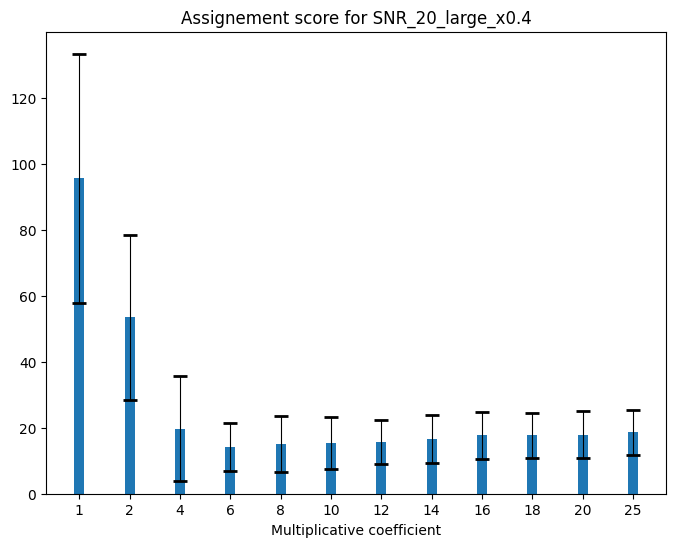

In [45]:
##### INITIALIZATION: GLASSO CALIBRATION PLOTS
##############################################

preci_margin = 5

#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/glasso_experiments/SNR_20_large_x0.4"
res_file_name_list = os.listdir(res_folder_root)
#-------------------------------------------------------------------------------------------

res_folder_list = [os.path.join(res_folder_root, file_name) for file_name in res_file_name_list]
print(res_file_name_list)

# x_tick_labels =  [1, 2, 4]
# x_tick_labels =  [0.6, 0.8, 1.0, 1.2, 1.4, 6, 8, 10, 12, 14, 20, 30]
x_tick_labels =  [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25]
# x_tick_labels =  [0.001, 0.01, 0.1, 1, 10, 100]
abscissa_pos = list(range(len(x_tick_labels)))  #["x" + str(i/10) for i in range(1, 11)]

cost_func_keys =  [str(x_tick) for x_tick in x_tick_labels] # ["statio normal cost"] #, "normal cost"]
metrics_keys =  ["assignement_cost"] #["f1_score"] #, "hausdorff"]

res_dic = get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, preci_margin)


##### PLOTTING: W.R.T GLASSO CALIBRATION PLOTS
##############################################

fig, axes = plt.subplots(1, (len(metrics_keys)), figsize=(8*len(metrics_keys), 6))

x_coords = abscissa_pos  #[float(x[1:]) for x in abscissa_pos]
##### precision
# plot_bar_and_scatter(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "f1_score", axes[0], shift=0.3, to_label=True)
y = []
y_err = []
for i, cost_func in enumerate(cost_func_keys):
    y.append(res_dic[cost_func]["assignement_cost"]["mean"][0])
    y_err.append(res_dic[cost_func]["assignement_cost"]["std"][0])
axes.bar(x = x_coords, height=y, yerr=y_err, width=0.2, error_kw=error_kw)
    # scatter plot based on the raw values
    # add_raw_scatter_to_plot(abscissa_pos, res_dic, "assignement_cost", cost_func, axes)


axes.set_title(f'Assignement score for {res_folder_root.split("/")[-1]}')
axes.set_ylim(bottom=0)
axes.set_xlabel("Multiplicative coefficient")
axes.set_xticks(x_coords, x_tick_labels)


##### CAPTIONNING AND METADATA
##############################

# fig.suptitle("ABLATION STUDY \nER graphs; N_nodes=N=20; SNR=10; segment_length=0.1*N(N-1)/2; N_exp=1000")
# fig.subplots_adjust(bottom=0.17, top=0.85)
# fig.legend(handles=legend_elements, loc='lower center', ncols=6)


In [ ]:
##### INITIALIZATION: W.R.T MARGIN PLOTS
########################################

#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_8"
res_file_name_list = os.listdir(res_folder_root)
#-------------------------------------------------------------------------------------------

res_folder_list = [os.path.join(res_folder_root, file_name + '/metrics') for file_name in res_file_name_list]
print(res_file_name_list)

x_tick_labels =  list(range(5, 105, 5))
abscissa_pos = list(range(len(x_tick_labels)))  #["x" + str(i/10) for i in range(1, 11)]

cost_func_keys = ["statio normal cost"] #, "normal cost"]
colors_per_cost_func = {"statio normal cost": "darkorange"} #, "normal cost": "dodgerblue"}
metrics_keys =  ["f1_score"] #, "hausdorff"]

per_margin_res_dic = {}

for preci_margin_val in x_tick_labels:
    per_margin_res_dic[preci_margin_val] = get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, preci_margin_val)


##### PLOTTING: W.R.T MARGIN PLOTS
##################################

fig, axes = plt.subplots(1, (len(metrics_keys)), figsize=(8*len(metrics_keys), 6))

x_coords = x_tick_labels # abscissa_pos  #[float(x[1:]) for x in abscissa_pos]

##### precision
# plot_bar_and_scatter(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "f1_score", axes[0], shift=0.3, to_label=True)
standard_plot_plus_fill_between_wrt_margin(cost_func_keys, per_margin_res_dic, x_coords, colors_per_cost_func, "f1_score", x_tick_labels, axes, to_label=True, alpha=0)


axes.set_ylim(bottom=0, top=1.1)
axes.set_ylabel("F1 score")
axes.set_xlabel("Margin (in number of samples)")
# axes.set_xticks(x_coords, x_tick_labels)


##### CAPTIONNING AND METADATA
##############################

# fig.suptitle("ABLATION STUDY \nER graphs; N_nodes=N=20; SNR=10; segment_length=0.1*N(N-1)/2; N_exp=1000")
# fig.subplots_adjust(bottom=0.17, top=0.85)
# fig.legend(handles=legend_elements, loc='lower center', ncols=6)


In [ ]:
##### INITIALIZATION: W.R.T MARGIN PLOTS
########################################

fig, axes = plt.subplots(1, (len(metrics_keys)), figsize=(8*len(metrics_keys), 6))

#-----------------------------------------------------------------------------------------
list_of_res_folder_root = [
    "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_8",
    "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_4",
    "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_2"
]

colors_per_folder_root = [
    {"normal cost": "dodgerblue", "statio normal cost": "darkorange",},
    {"statio normal cost": "peru"},
    {"statio normal cost": "teal"}
]
#-----------------------------------------------------------------------------------------


for i, res_folder_root in enumerate(list_of_res_folder_root) :

    res_folder_list = [os.path.join(res_folder_root, file_name + '/metrics') for file_name in res_file_name_list]
    print(res_file_name_list)

    x_tick_labels =  list(range(5, 205, 5))
    abscissa_pos = list(range(len(x_tick_labels)))  #["x" + str(i/10) for i in range(1, 11)]

    colors_per_cost_func = colors_per_folder_root[i]
    cost_func_keys = list(colors_per_cost_func.keys())
    metrics_keys = ["f1_score"] #, "hausdorff"]

    per_margin_res_dic = {}

    for preci_margin_val in x_tick_labels:
        per_margin_res_dic[preci_margin_val] = get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, preci_margin_val)


    ##### PLOTTING: W.R.T MARGIN PLOTS
    ##################################

    x_coords = x_tick_labels # abscissa_pos  #[float(x[1:]) for x in abscissa_pos]

    ##### precision
    # plot_bar_and_scatter(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "f1_score", axes[0], shift=0.3, to_label=True)
    standard_plot_plus_fill_between_wrt_margin(cost_func_keys, per_margin_res_dic, x_coords, colors_per_cost_func, "f1_score", x_tick_labels, axes, to_label=True, alpha=0)


axes.set_ylim(bottom=0, top=1.1)
axes.set_ylabel("F1 score")
axes.set_xlabel("Margin (in number of samples)")
# axes.set_xticks(x_coords, x_tick_labels)


legend_elements = []
for i, res_folder_root in enumerate(list_of_res_folder_root):
    for cost_func in list(colors_per_folder_root[i].keys()):
        color = colors_per_folder_root[i][cost_func]
        legend_elements.append(Line2D([0], [0], color=color, lw=0.01, marker='x', label=f"{res_folder_root[-12:]}_{COST_FUNC_NAME_TO_PLOT_LABEL[cost_func]}"),)


##### CAPTIONNING AND METADATA
##############################

axes.legend(handles=legend_elements, loc="lower right", ncols=1)#len(legend_elements))

# fig.suptitle("ABLATION STUDY \nER graphs; N_nodes=N=20; SNR=10; segment_length=0.1*N(N-1)/2; N_exp=1000")
# fig.subplots_adjust(bottom=0.17, top=0.85)
# fig.legend(handles=legend_elements, loc='lower center', ncols=6)


In [ ]:
##### INITIALIZATION 1 ABLATION STUDY
########################################

preci_margin = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
legend_elements = []

#-------------------------------------------------------------------------------------------
res_fold_root = "results_1/synthetic/within_hypothesis_noisy/varying_segment_length/large_x0.1_SNR_10ER_20_nodes_deg_10_bandwidth_0.4_80exp"
res_file_name_list = os.listdir(res_folder_root)
#-------------------------------------------------------------------------------------------

colors_per_cost_func = {"statio normal cost": "darkorange", "normal cost": "dodgerblue"}
metrics_keys = ["f1_score", "hausdorff"]

cost_func_keys = ["normal cost"]
res_dic = get_res_per_metric_per_cost_func([res_fold_root], cost_func_keys, metrics_keys, preci_margin)
x_coords = [0.1]
plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "f1_score", axes[0], shift=0.03, to_label=True)
plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "hausdorff", axes[1], shift=0.03)
legend_elements.append(Line2D([0], [0], color=colors_per_cost_func["normal cost"], lw=3, label="A. normal mle cost"))

cost_func_keys = ["statio normal cost"]
res_dic = get_res_per_metric_per_cost_func([res_fold_root], cost_func_keys, metrics_keys, preci_margin)
x_coords = [0.2]
plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "f1_score", axes[0], shift=0.03, to_label=True)
plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "hausdorff", axes[1], shift=0.03)
legend_elements.append(Line2D([0], [0], color=colors_per_cost_func["statio normal cost"], lw=3, label="B. statio cost"))


##### INITIALIZATION 2 ABLATION STUDY
######################################

res_folder_root = "results_1/synthetic/ablation_study/large_x0.1"
res_file_name_list = os.listdir(res_folder_root)
res_file_name_list.sort()
res_folder_list = [os.path.join(res_folder_root, file_name) for file_name in res_file_name_list]
cost_func_keys = ["statio normal cost"]
metrics_keys = ["f1_score", "hausdorff"]
colors_per_file = ["lightcoral", "darkorchid", "peru", "teal"]
x_coords_top = [0.3, 0.4, 0.5, 0.6]
labels = ["C. connectivity modified 0.05", "D. other ER graph", "E. exp sim geographical graphs", "F. diagonal in canonical basis"]

for i, file_name in enumerate(res_folder_list):

    colors_per_cost_func = {"statio normal cost": colors_per_file[i]}
    res_dic = get_res_per_metric_per_cost_func([file_name], cost_func_keys, metrics_keys, preci_margin)
    x_coords = [x_coords_top[i]]
    # precision
    plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "f1_score", axes[0], shift=0.03, to_label=True)
    # haussdorff
    plot_bar_and_scatter_ablation_study(cost_func_keys, res_dic, x_coords, x_coords[0], colors_per_cost_func, "hausdorff", axes[1], shift=0.03)
    legend_elements.append(Line2D([0], [0], color=colors_per_file[i], lw=3, label=labels[i]))


axes[0].set_title(F'F1 Score (margin = {preci_margin})')
axes[0].set_xticks([i/10 for i in range(1, 7)], ["A", "B", "C", "D", "E", "F"])
axes[0].set_xlabel("Different settings")
axes[1].set_title('Haussdorff')
axes[1].set_xticks([i/10 for i in range(1, 7)], ["A", "B", "C", "D", "E", "F"])
axes[1].set_xlabel("Different settings")
axes[1].set_ylim(bottom=0, top=400)


##### CAPTIONNING AND METADATA
##############################

fig.suptitle("ABLATION STUDY \nER graphs; N_nodes=N=20; SNR=10; segment_length=0.1*N(N-1)/2; N_exp=1000")
fig.subplots_adjust(bottom=0.17, top=0.85)
fig.legend(handles=legend_elements, loc='lower center', ncols=6)


In [ ]:
##### INITIALIZATION WITH DIFFERENT GRAPH TYPES
###############################################

PRECI_RECALL_MARGIN = 5

#-------------------------------------------------------------------------------------------
pred_path = "results_1/synthetic/within_hypothesis/varying_segment_length"
file_names = os.listdir(pred_path)
PRED_FOLDER = [os.path.join(pred_path, file_name) for file_name in file_names if '.txt' not in file_name]
#-------------------------------------------------------------------------------------------

cost_func_keys = ["statio normal cost", "normal cost"]
markers = ['o', "s"]
linestyles = ["dashed", "dotted"]
metrics_keys = ["f1_score", "hausdorff"]
abscissa_pos =  ["x1", "x1.5", "x2", "x2.5", "x4"]
graph_types = ["ER"] # "exp_geo", "KNN_geo", 
graph_colors = ['darkorange'] #, 'dodgerblue', 'darkorchid']
shift = 3


##### PLOTTING
##############

fig, axes = plt.subplots(1, (len(metrics_keys)), figsize=(7*len(metrics_keys), 5)) #, layout='constrained')

for i in range(len(graph_types)):

    # re-arrange the folder name so they have the right position for meaningful plotting
    graph_name = graph_types[i]
    res_folder_list = [folder_name for folder_name in PRED_FOLDER if graph_name in folder_name]
    print(res_folder_list)
    res_dic = get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, PRECI_RECALL_MARGIN)

    x_coords = [float(x[1:]) + i*shift for x in abscissa_pos]
    plot_scatter_errorbar(x_coords, cost_func_keys, graph_colors[i], markers, linestyles, "f1_score", res_dic, ax=axes[0])
    axes[0].set_xlabel("Number of nodes")
    axes[0].set_title(F'F1 SCORE (margin = {PRECI_RECALL_MARGIN})')
    plot_scatter_errorbar(x_coords, cost_func_keys, graph_colors[i], markers, linestyles, "hausdorff", res_dic, ax=axes[1])
    axes[1].set_xlabel("Number of nodes")
    axes[1].set_title('Haussdorff')
    axes[1].set_ylim(bottom=0)

x_tick_loc = [float(x[1:]) + 0* shift for x in abscissa_pos]
axes[0].set_xticks(x_tick_loc, abscissa_pos)
axes[1].set_xticks(x_tick_loc, abscissa_pos)


##### CAPTIONNING AND METADATA
##############################

legend_elements = [
    Line2D([0], [0], color='k', lw=0.01, marker=markers[0], linestyle=linestyles[0], label=cost_func_keys[0]),
    Line2D([0], [0], color='k', lw=0.01, marker=markers[1], linestyle=linestyles[1], label=cost_func_keys[1]),
    Line2D([0], [0], color=graph_colors[0], lw=3, label=graph_types[0]),
    # Line2D([0], [0], color=graph_colors[1], lw=3, label=graph_types[1]),
    # Line2D([0], [0], color=graph_colors[2], lw=3, label=graph_types[2]),
]               
fig.suptitle("Comparison of cost functions with respect to the minimum segment length")
fig.subplots_adjust(bottom=0.17)
fig.legend(handles=legend_elements, loc="lower center", ncols=len(legend_elements))

In [ ]:
##### INITIALIZATION RULE BASED FILE SELECTION
################################################

preci_margin = 2
TO_SAVE = True

#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypo_censor_breakdown/SNR_20_large_x0.4/varying_breakdown_length"
res_file_name_list = os.listdir(res_folder_root)
res_file_name_list.sort()
# res_file_name_list_left = res_file_name_list[5:]
# res_file_name_list_right = res_file_name_list[:5]
# res_file_name_list = res_file_name_list_left + res_file_name_list_right
# res_file_name_list = [file_name for file_name in res_file_name_list if not '.txt' in file_name]
# res_file_name_list = [file_name for file_name in res_file_name_list if len(file_name) < 66]
# res_file_name_list = [file_name for file_name in res_file_name_list if '0_' in file_name[:20] or '5_' in file_name]
# last_one = res_file_name_list.pop()
# res_file_name_list.insert(0, last_one)
res_file_name_list = ['large_x0.4_SNR_20_NBbd_6_bklength_50_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_100_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_150_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_200_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_250_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_350_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_400_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_450_ER_20_nodes_deg_10_bandwidth_0.4_80_exp', 'large_x0.4_SNR_20_NBbd_6_bklength_500_ER_20_nodes_deg_10_bandwidth_0.4_80_exp']
#-------------------------------------------------------------------------------------------

res_folder_list = [os.path.join(res_folder_root, file_name) for file_name in res_file_name_list]
print(res_file_name_list)

abscissa_pos = range(len(res_folder_list))  #["x" + str(i/10) for i in range(1, 11)]
x_tick_labels =  [x for x in range(50, 550, 50)] #[-5, 0, 5, 10, 15, 20]   #[file_name[7:10] + '%' for file_name in res_file_name_list] 

cost_func_keys = ["statio normal cost", "normal cost"]
colors_per_cost_func = {"statio normal cost": "darkorange", "normal cost": "dodgerblue"}
metrics_keys = ["f1_score"] #, "hausdorff"]

res_dic = get_res_per_metric_per_cost_func(res_folder_list, cost_func_keys, metrics_keys, preci_margin)


##### PLOTTING
##############

fig, axes = plt.subplots(1, (len(metrics_keys)), figsize=(8*len(metrics_keys), 6))

x_coords = abscissa_pos  #[float(x[1:]) for x in abscissa_pos]
##### precision
# plot_bar_and_scatter(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "f1_score", axes[0], shift=0.3, to_label=True)
standard_plot_plus_fill_between(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "f1_score", axes, to_label=True)
axes.set_title(F'F1 SCORE (margin = {preci_margin})')
axes.set_ylim(bottom=0)
axes.set_xlabel("Breakdown length (in number of samples)")
axes.set_xticks(x_coords, x_tick_labels)
##### haussdorff
# plot_bar_and_scatter(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "hausdorff", axes[1], shift=0.3)
# # standard_plot_plus_fill_between(cost_func_keys, res_dic, x_coords, colors_per_cost_func, "hausdorff", axes[1])
# axes[1].set_title('Haussdorff')
# axes[1].set_xlabel("Breakdown length (in number of samples)")
# axes[1].set_ylim(bottom=0)
# axes[1].set_xticks(x_coords, x_tick_labels)

#### addditional content
# additional_result_file = 'results_1/synthetic/within_hypothesis/varying_segment_length/large_x0.4_SNR_inf_ER_20_nodes_deg_10_bandwidth_0.4_1000_exp'
# additional_res_dic = get_res_per_metric_per_cost_func([additional_result_file], ["normal cost"], ['f1_score'], preci_margin)
# mean_normal_val = additional_res_dic['normal cost']['f1_score']['mean']
# axes.axhline(y=mean_normal_val, xmin=0, xmax=1, color='dodgerblue', label='mean mle normal cost')


# axes.legend(loc='center right')
axes.legend(loc=(0.7, 0.35))


##### CAPTIONNING AND METADATA
##############################

legend_elements = [
    Line2D([0], [0], color=list(colors_per_cost_func.values())[0], lw=3, label=list(colors_per_cost_func.keys())[0]),
    # Line2D([0], [0], color=list(colors_per_cost_func.values())[1], lw=3, label=list(colors_per_cost_func.keys())[1]),
    # Line2D([0], [0], color=list(colors_per_cost_func.values())[1], lw=3, label=list(colors_per_cost_func.keys())[1]),
    # Line2D([0], [0], color=graph_colors[1], lw=3, label=graph_types[1]),
    # Line2D([0], [0], color=graph_colors[2], lw=3, label=graph_types[2]),
] 

metadata = get_metadata_for_plot(res_folder_list)
subtitle = define_subtitle_based_on_exp_metadata(metadata)
suptitle = "Evaluation of the robustness with respect to censor breakdown."
# suptitle = "Evaluation of the robustness with respect to additive gaussian white noise."
# suptitle = "Evaluation of the robustness with respect to the quality of the observed connectivity of the graph"
# suptitle = "Evaluation of the influence of the stationarity segment length."
title = suptitle + '\n' + subtitle + ' ~ Nb breakdowns=' + str(6)

fig.suptitle(title)
fig.subplots_adjust(bottom=0.17, top=0.85)
# fig.legend(handles=legend_elements, loc="lower center", ncols=len(legend_elements))
# fig.legend(loc="lower center", ncols=4)

if TO_SAVE:
    plot_path = "images/results_1/robustness_with_respect_to_censor_breakdown/varying_breakdown_length/SNR_20_large_x0.4_NBbk_6"
    plot_name =   f'only_f1_mean_std_standard_plot_margin_{preci_margin}'  #     f'bar_plot_margin_{preci_margin}' #    
    plt.savefig(f"{plot_path}/{plot_name}")
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)

## References

<a id="Izenman2008">[Izenman2008]</a>
Izenman Alan J. (2008). Introduction to Random-Matrix Theory [asc.ohio-state.edu]

<a id="Ryan2023">[Ryan2023]</a>
Sean Ryan and Rebecca Killick. Detecting Changes in Covariance via Random Matrix Theory. Technometrics, 65(4):480–491, October 2023. Publisher: Taylor & Francis